In [2]:
from datasets import load_dataset

ds = load_dataset("food101",cache_dir='/data/ywang/play_with_AI/run/dataset')

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/75750 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/25250 [00:00<?, ? examples/s]

In [3]:
labels = ds["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

id2label[2]
"baklava"

'baklava'

In [4]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k",cache_dir = '/data/ywang/play_with_AI/run')

In [5]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)

def preprocess_train(example_batch):
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

def preprocess_val(example_batch):
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [6]:
train_ds = ds["train"]
val_ds = ds["validation"]

train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [7]:
import torch

def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

In [9]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    label2id=label2id,
    id2label=id2label,
    cache_dir = '/data/ywang/play_with_AI/run',
    ignore_mismatched_sizes=True,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["query", "value"],
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
model = get_peft_model(model, config)
model.print_trainable_parameters()
"trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7712775047664294"

trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7712775047664294


'trainable params: 667,493 || all params: 86,543,818 || trainable%: 0.7712775047664294'

In [12]:
from transformers import TrainingArguments, Trainer

account = "yqqxyy"
peft_model_id = f"{account}/google/vit-base-patch16-224-in21k-lora"
batch_size = 128

args = TrainingArguments(
    peft_model_id,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    label_names=["labels"],
)

In [13]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    data_collator=collate_fn,
)
trainer.train()

/data/ywang/anaconda3/envs/diffusion/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss
1,0.989700,0.514567
2,0.755000,0.426069
3,0.672600,0.387253
4,0.625600,0.367526
5,0.584900,0.359584


/data/ywang/anaconda3/envs/diffusion/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/data/ywang/anaconda3/envs/diffusion/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/data/ywang/anaconda3/envs/diffusion/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/data/ywang/anaconda3/envs/diffusion/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68

TrainOutput(global_step=185, training_loss=0.8810681665265883, metrics={'train_runtime': 3170.088, 'train_samples_per_second': 119.476, 'train_steps_per_second': 0.058, 'total_flos': 2.960446615709184e+19, 'train_loss': 0.8810681665265883, 'epoch': 5.0})

In [14]:
model.save_pretrained(save_directory='/data/ywang/play_with_AI/run/yqqxyy-food101-lora')

In [20]:
from peft import PeftConfig, PeftModel
from transformers import AutoImageProcessor
from PIL import Image
import requests

config = PeftConfig.from_pretrained("/data/ywang/play_with_AI/run/yqqxyy-food101-lora")
model = AutoModelForImageClassification.from_pretrained(
    config.base_model_name_or_path,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,cache_dir='/data/ywang/play_with_AI/run/models--google--vit-base-patch16-224-in21k'
)
model = PeftModel.from_pretrained(model, "/data/ywang/play_with_AI/run/yqqxyy-food101-lora")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [17]:
config.base_model_name_or_path

'google/vit-base-patch16-224-in21k'

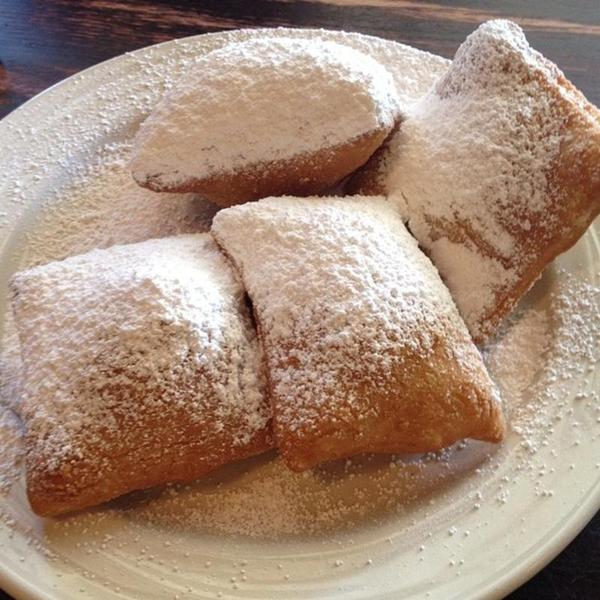

In [23]:
url = "https://image.zmenu.com/large/1402222/20141108005813913730.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

In [24]:
encoding = image_processor(image.convert("RGB"), return_tensors="pt")

In [25]:
with torch.no_grad():
    outputs = model(**encoding)
    logits = outputs.logits

predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])
"Predicted class: beignets"

Predicted class: beignets


'Predicted class: beignets'